# Imports

In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] ='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2023-01-11 12:02:49.306234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 12:02:49.950250: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/TensorRT-8.5.2.2/lib:/usr/local/cuda-11.5/lib64::/home/minuano/.mujoco/mjpro150/bin
2023-01-11 12:02:49.950325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/TensorRT-8.5.2.2/lib:/us

In [2]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

import optax

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

# Model Definitions (TODO: Documentation)

## Level 0: Simple CNN

In [3]:
class SimpleMNISTCNN(nn.Module):

    @nn.compact
    def __call__(self, x): # x -> 28 x 28 x 1
        x = nn.Conv(features=32, kernel_size=(3, 3))(x) # x -> BS x 26 x 26 x 32
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) # x -> BS x 14 x 14 x 32
        x = nn.Conv(features=64, kernel_size=(3, 3))(x) # x -> BS x 12 x 12 x 64
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) # x -> BS x 6 x 6 x 64
        x = x.reshape((x.shape[0], -1)) # x ->BS x 2304
        x = nn.Dense(features=256)(x) # x -> BS x 256
        x = nn.relu(x)
        x = nn.Dense(features=10)(x) # x -> BS x 10
        return x


## Level 1: CNN with BatchNorm and DropOut

In [4]:
class BNDOMNISTCNN(nn.Module):
    
    @nn.compact
    def __call__(self, x, training):
        ## CONV BLOCK 1
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        ## CONV BLOCK 2
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        # FLATTEN
        x = x.reshape((x.shape[0], -1))
        # DENSE BLOCK 1
        x = nn.Dense(features=256)(x)
        x = nn.Dropout(0.2, deterministic=not training)(x)
        x = nn.relu(x)
        # DENSE BLOCK 2
        x = nn.Dense(features=128)(x)
        x = nn.Dropout(0.2, deterministic=not training)(x)
        x = nn.relu(x)
        # LOGITS
        x = nn.Dense(features=10)(x)
        return x

## Level 3: CNN with Residual Blocks

In [5]:
class BNDOMNISTResNet(nn.Module):

    @nn.compact
    def __call__(self, x, training):
        ## RESIDUAL BLOCK 0-1
        y = nn.Conv(features=16, kernel_size=(3, 3), padding='SAME')(x)
        y = nn.BatchNorm(use_running_average=not training)(y)
        x = x + y
        x = nn.relu(x)
        ## RESIDUAL BLOCK 0-2
        y = nn.Conv(features=16, kernel_size=(3, 3), padding="SAME")(x)
        y = nn.BatchNorm(use_running_average=not training)(y)
        x = x + y
        x = nn.relu(x)
        ## DOWNSAMPLE 0
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        ## RESIDUAL BLOCK 1-1
        y = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        y = nn.BatchNorm(use_running_average=not training)(y)
        x = x + y
        x = nn.relu(x)
        ## RESIDUAL BLOCK 1-2
        y = nn.Conv(features=32, kernel_size=(3, 3), padding="SAME")(x)
        y = nn.BatchNorm(use_running_average=not training)(y)
        x = x + y
        x = nn.relu(x)
        ## DOWNSAMPLE 1
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        # FLATTEN
        x = x.reshape((x.shape[0], -1))
        # DENSE BLOCK 1
        x = nn.Dense(features=256)(x)
        x = nn.Dropout(0.2, deterministic=not training)(x)
        x = nn.relu(x)
        # DENSE BLOCK 2
        x = nn.Dense(features=128)(x)
        x = nn.Dropout(0.2, deterministic=not training)(x)
        x = nn.relu(x)
        # LOGITS
        x = nn.Dense(features=10)(x)
        return x


## Level 4: Port ConvNeXt to JAX (with modular implementation)

In [6]:
from typing import Optional, Tuple

class Identity(nn.Module):
    """Do nothing!
    """
    
    @nn.compact
    def __call__(self, inputs, **kwargs):
        return inputs

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
        Attributes:
            rate: the drop probability.
            deterministic: whether or not to apply droppath.
            rng_collection: the rng collection name to use when requesting an rng key.
    """
    rate: float
    deterministic: Optional[bool] = None
    rng_collection: str = 'dropout'

    @nn.compact
    def __call__(self, inputs, deterministic: Optional[bool] = None):
        deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
        
        if (self.rate == 0.) or deterministic:
            return inputs

        keep_prob = 1. - self.rate
        shape = (inputs.shape[0],) + (1,)*(inputs.ndim-1) # converts (s1, s2, s3, ...) to (s1, 1, 1, ...)
        rng = self.make_rng(self.rng_collection)
        # create a mask of 0s and 1s with p(0) = self.rate, p(1) = keep_prob
        random_mask = keep_prob + jax.random.uniform(rng, shape, dtype=inputs.dtype)
        random_mask = jnp.floor(random_mask) 
        return (inputs/keep_prob) * random_mask
    
class Block(nn.Module):
    """A ConvNeXt block.
    """
    dim: int
    drop_prob: Optional[float] = 0.
    layer_scale_init_value: Optional[float] = 1e-6

    def setup(self):
        self.dwconv = nn.Conv(self.dim, kernel_size=(7,7), padding='SAME', feature_group_count=self.dim)
        self.norm = nn.LayerNorm()
        self.pwconv1 = nn.Dense(4*self.dim)
        self.act = nn.gelu
        self.pwconv2 = nn.Dense(self.dim)
        self.gamma = self.param(
            'gamma',
            lambda key, s: self.layer_scale_init_value * jnp.ones(s, jnp.float32),
            self.dim
        ) if self.layer_scale_init_value > 0 else None
        self.drop_path = DropPath(self.drop_prob) if self.drop_prob > 0. else Identity()

    def __call__(self, x, training=False):
        input = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        
        x = input + self.drop_path(x, deterministic=not training)
        return x

class ConvNeXt(nn.Module):
    """JAX port of the ConvNeXt model
    """
    in_chans: int = 3
    num_classes: int = 10
    depths: Tuple[int] = (3, 3, 9, 3)
    dims: Tuple[int] = (96, 192, 384, 768)
    drop_path_rate: float = 0.
    layer_scale_init_value: float = 1e-6
    head_init_scale: float = 1.

    def setup(self):
        downsample_layers = []
        stem = nn.Sequential(
            [nn.Conv(self.dims[0], kernel_size=(4,4), strides=4),
            nn.LayerNorm()]
        )
        downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                [nn.LayerNorm(),
                nn.Conv(self.dims[i+1], kernel_size=(2,2), strides=2)]
            )
            downsample_layers.append(downsample_layer)
        self.downsample_layers = downsample_layers
        
        stages = []
        dp_rates=[x.item() for x in np.linspace(0, self.drop_path_rate, np.sum(self.depths))]
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                [Block(dim=self.dims[i], drop_prob=dp_rates[cur+j],
                layer_scale_init_value=self.layer_scale_init_value) for j in range(self.depths[i])]
            )
            stages.append(stage)
            cur += self.depths[i]
        self.stages = stages

        self.norm = nn.LayerNorm()
        self.head = nn.Dense(self.num_classes)

    def __call__(self, x, training=False):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x, training=training)
        x = self.norm(x.mean([-2, -1]))
        x = self.head(x)
        return x

## Level 5: Load pretrained ConvNeXt weights from PyTorch onto the Flax model

In [ ]:
# TODO

# Utilities

In [7]:
def loss_and_metrics(logits, labels):
    loss =  jnp.mean(
        # takes care of one-hot encoding by itself
        optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    )
    # argmax on the last dim because we expect logits to be of shape (batch_size, n_classes)
    accuracy = jnp.mean(
        jnp.argmax(logits, -1) == labels
    )
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    return metrics

In [8]:
def get_datasets(ds="mnist", shape=None, half_precision=True):
    import importlib
    loader = importlib.import_module('keras.datasets.'+ds)
    (X_train, y_train), (X_test, y_test) = loader.load_data()
    X_train = np.expand_dims(np.float32(X_train)/255.0, -1)
    X_test = np.expand_dims(np.float32(X_test)/255.0, -1)
    if shape is not None:
        from skimage.transform import resize
        batch_dim_train = len(y_train)
        batch_dim_test = len(y_test)
        dtype = np.float32
        if half_precision:
            dtype = np.float16
        assert len(shape) == 2, "shape must be a tuple (H, W)."
        shape_train = (X_train.shape[0],) + shape + (X_train.shape[3],)
        shape_test = (X_test.shape[0],) + shape + (X_test.shape[3],)
        X_train_ts = np.zeros(shape_train, dtype=dtype)
        X_test_ts = np.zeros(shape_test, dtype=dtype)
        # TODO: Vectorize (vmap didn't work?)
        for i in range(batch_dim_train):
            X_train_ts[i] = resize(X_train[i], shape).astype(dtype)
        for i in range(batch_dim_test):
            X_test_ts[i] = resize(X_test[i], shape).astype(dtype)
        X_train = X_train_ts
        X_test = X_test_ts
    return (X_train, y_train), (X_test, y_test)

In [9]:
# TODO: don't waste last batch (pad last batch?)
def batch_generator(X, y, batch_size, rng=None):
    steps = len(y) // batch_size
    idxs = jnp.arange(0, len(y))
    if rng is not None:
        idxs = jax.random.permutation(rng, idxs, independent=True)
    idxs = idxs[:steps*batch_size]
    idxs = idxs.reshape((steps, batch_size))

    for idx in idxs:
        yield jnp.array(X[idx, ...]), jnp.array(y[idx, ...])

# Training Steps

In [10]:
@jax.jit
def train_step_bndo(state, X_batch, y_batch):
    # create a new dropout key
    dropout_train_key = jax.random.fold_in(state.dropout_key, state.step)
    def loss_fn(params, batch_stats, apply_fn):
        # first argument of apply_fn is always a variables pytree
        vars = {
            'params': params,
            'batch_stats': batch_stats
        }
        # apply_fn with non-empty `mutable` list ALSO returns a pytree of mutated_vars
        # from that pytree we can extract `batch_stats`
        logits, mutated_vars = apply_fn(
            vars,
            X_batch,
            training=True, # set this to ensure BN is recording stats and dropout is active
            mutable=['batch_stats'],
            rngs={'dropout': dropout_train_key} # feed new rng key for consumption by dropout layers
        )
        loss = jnp.mean(
            optax.softmax_cross_entropy_with_integer_labels(logits, y_batch)
        )
        return loss, (logits, mutated_vars['batch_stats'])
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, new_batch_stats)), grads = grad_fn(state.params, state.batch_stats, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    # update state.batch_stats after calculating updates by replacing old stats
    # NOTE: state.batch_stats = new_batch_stats doesn't work because state.batch_stats is frozen by design (FrozenDict)
    state = state.replace(batch_stats=new_batch_stats)
    metrics = loss_and_metrics(logits, y_batch)
    return state, metrics

In [11]:
@jax.jit
def train_step_convnext(state, X_batch, y_batch):
    dropout_train_key= jax.random.fold_in(state.dropout_key, state.step)
    def loss_fn(params, apply_fn):
        vars = {'params': params}
        logits = apply_fn(
            vars, X_batch, training=True, rngs={'dropout': dropout_train_key}
        )
        loss = jnp.mean(
            optax.softmax_cross_entropy_with_integer_labels(logits, y_batch)
        )
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    metrics = loss_and_metrics(logits, y_batch)
    return state, metrics

In [12]:
@jax.jit
def train_step(state, X_batch, y_batch):
    def loss_fn(params, apply_fn):
        logits = apply_fn(
            {'params': params},
            X_batch
        )
        loss = jnp.mean(
            optax.softmax_cross_entropy_with_integer_labels(logits, y_batch)
        )
        return loss, logits
    # create a grad_fn from loss_fn
    # try to put the variable with respect to which we want to differentiate at position 0 (`argnums` does some weird stuff)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params, state.apply_fn)
    # apply gradient updates to the state
    state = state.apply_gradients(grads=grads)
    # calculate metrics
    metrics = loss_and_metrics(logits, y_batch)
    return state, metrics

# Eval Steps

In [13]:
@jax.jit
def eval_step_bndo(state, X_batch, y_batch):
    vars = {
        'params': state.params,
        'batch_stats': state.batch_stats
    }
    # apply_fn called with training=False to turn off dropout
    # and use running stats from training
    logits = state.apply_fn(
        vars, X_batch, training=False        
    )
    return loss_and_metrics(logits, y_batch)

In [14]:
@jax.jit
def eval_step_convnext(state, X_batch, y_batch):
    logits = state.apply_fn(
        {'params': state.params}, X_batch, training=False
    )
    return loss_and_metrics(logits, y_batch)

In [15]:
@jax.jit
def eval_step(state, X_batch, y_batch):
    logits = state.apply_fn(
        {'params': state.params},
        X_batch
    )
    return loss_and_metrics(logits, y_batch)

# Model Train and Eval

In [16]:
# impossible to jit because of jax.device_get
def train_one_epoch(state, X_train, y_train, batch_size, epoch, rng, mode='bndo'):
    # TODO: scalability
    if mode=='bndo':
        train_fn = train_step_bndo
    elif mode=='convnext':
        train_fn = train_step_convnext
    else:
        train_fn = train_step
    
    batch_metrics = []
    # collect batch metrics from each batch of data
    for X_batch, y_batch in tqdm(batch_generator(X_train, y_train, batch_size, rng), total=len(y_train)//batch_size):
        state, metrics = train_fn(state, X_batch, y_batch)
        batch_metrics.append(metrics)
    # call device_get to transfer them to CPU memory (NOTE: this is NOT jittable)
    training_batch_metrics = jax.device_get(batch_metrics)
    # build a pytree of metrics similar to the one that loss_and_metrics returns
    training_epoch_metrics = {
        k: np.mean([metrics[k] for metrics in training_batch_metrics])
        for k in training_batch_metrics[0]
    }

    print(f'Training - epoch: {epoch:d} | loss: {training_epoch_metrics["loss"]:.4f} | accuracy: {training_epoch_metrics["accuracy"]:.4f}')

    return state, training_epoch_metrics

In [17]:
# impossible to jit because of jax.device_get
def eval_model(state, X_test, y_test, batch_size, epoch, mode='bndo'):
    if mode=='bndo':
        eval_fn = eval_step_bndo
    elif mode=='convnext':
        eval_fn = eval_step_convnext
    else:
        eval_fn = eval_step

    batch_metrics = []

    for X_batch, y_batch in tqdm(batch_generator(X_test, y_test, batch_size), total=len(y_test)//batch_size):
        metrics = eval_fn(state, X_batch, y_batch)
        batch_metrics.append(metrics)

    test_batch_metrics = jax.device_get(batch_metrics)
    test_metrics = {
        k: np.mean([metrics[k] for metrics in test_batch_metrics])
        for k in test_batch_metrics[0]
    }
    
    print(f'Testing  - epoch: {epoch:d} | loss: {test_metrics["loss"]:.4f} | accuracy: {test_metrics["accuracy"]:.4f}')
    
    return test_metrics

In [18]:
def train_end_to_end(
    state, training_mode,
    X_train, y_train, X_test, y_test, rng,
    lr=4e-3, num_epochs=10, batch_size=40,
    visualize=True, checkpoint=True, ckpt_dir='checkpoints', model_name = "Model"
):
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []

    for epoch in range(1, num_epochs + 1):
        rng, input_rng = jax.random.split(rng)
        state, train_metrics = train_one_epoch(state, X_train, y_train, batch_size, epoch, input_rng, mode=training_mode)
        test_metrics = eval_model(state, X_test, y_test, batch_size, epoch, mode=training_mode)
        train_loss.append(train_metrics['loss']); train_acc.append(train_metrics['accuracy'])
        test_loss.append(test_metrics['loss']); test_acc.append(test_metrics['accuracy'])

    if checkpoint:
        ckpt = {
            'model': state,
            'config':{
            'lr': lr,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'model_name': model_name
            }
        }
        checkpoints.save_checkpoint(
            ckpt_dir=ckpt_dir,
            target=ckpt,
            step=0,
            overwrite=False,
            keep=1,
            prefix=training_mode
        )

    if visualize:
        fig, axes = plt.subplots(1, 2)

        axes[0].plot(train_loss, label='Train')
        axes[0].plot(test_loss, label='Test')
        axes[0].set_title('Training Loss vs. Test Loss')
        axes[0].legend()

        axes[1].plot(train_acc, label='Train')
        axes[1].plot(test_acc, label='Test')
        axes[1].set_title('Training Accuracy vs. Test Accuracy')
        axes[1].legend()

        plt.suptitle(str(model_name))
        plt.tight_layout()
        plt.show();

# Experiments

In [19]:
### CUSTOM TRAINSTATE FOR BATCH NORM AND DROPOUT
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict = None
    dropout_key: jax.random.KeyArray = None

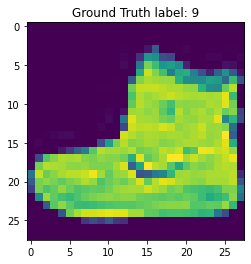

In [20]:
(X_train, y_train), (X_test, y_test) = get_datasets(ds="fashion_mnist")
plt.title(f'Ground Truth label: {y_train[0]}')
plt.imshow(X_train[0]);

In [21]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# model = SimpleMNISTCNN()
# model = BNDOMNISTCNN()
model = BNDOMNISTResNet()
# model = ConvNeXt(in_chans=1, drop_path_rate=0.2)

variables = model.init(init_rng, jnp.ones([1, 28, 28, 1]), training=False)
# variables = model.init(init_rng, jnp.ones([1, 224, 224, 1]), training=False)

params = variables['params']
batch_stats = variables['batch_stats']

100%|██████████| 1500/1500 [00:11<00:00, 132.23it/s]


Training - epoch: 1 | loss: 0.4603 | accuracy: 0.8357


100%|██████████| 250/250 [00:01<00:00, 203.56it/s]


Testing  - epoch: 1 | loss: 0.3003 | accuracy: 0.8915


100%|██████████| 1500/1500 [00:06<00:00, 224.95it/s]


Training - epoch: 2 | loss: 0.2888 | accuracy: 0.8979


100%|██████████| 250/250 [00:00<00:00, 1061.79it/s]


Testing  - epoch: 2 | loss: 0.2561 | accuracy: 0.9072


100%|██████████| 1500/1500 [00:06<00:00, 239.44it/s]


Training - epoch: 3 | loss: 0.2420 | accuracy: 0.9154


100%|██████████| 250/250 [00:00<00:00, 1048.10it/s]


Testing  - epoch: 3 | loss: 0.3041 | accuracy: 0.8948


100%|██████████| 1500/1500 [00:06<00:00, 243.43it/s]


Training - epoch: 4 | loss: 0.2169 | accuracy: 0.9233


100%|██████████| 250/250 [00:00<00:00, 1114.11it/s]


Testing  - epoch: 4 | loss: 0.2425 | accuracy: 0.9140


100%|██████████| 1500/1500 [00:05<00:00, 252.37it/s]


Training - epoch: 5 | loss: 0.1934 | accuracy: 0.9315


100%|██████████| 250/250 [00:00<00:00, 1056.18it/s]


Testing  - epoch: 5 | loss: 0.2387 | accuracy: 0.9173


100%|██████████| 1500/1500 [00:06<00:00, 231.97it/s]


Training - epoch: 6 | loss: 0.1783 | accuracy: 0.9374


100%|██████████| 250/250 [00:00<00:00, 1021.18it/s]


Testing  - epoch: 6 | loss: 0.2408 | accuracy: 0.9198


100%|██████████| 1500/1500 [00:06<00:00, 246.45it/s]


Training - epoch: 7 | loss: 0.1646 | accuracy: 0.9410


100%|██████████| 250/250 [00:00<00:00, 1099.66it/s]


Testing  - epoch: 7 | loss: 0.2284 | accuracy: 0.9244


100%|██████████| 1500/1500 [00:05<00:00, 257.16it/s]


Training - epoch: 8 | loss: 0.1535 | accuracy: 0.9464


100%|██████████| 250/250 [00:00<00:00, 1145.43it/s]


Testing  - epoch: 8 | loss: 0.2799 | accuracy: 0.9113


100%|██████████| 1500/1500 [00:06<00:00, 214.59it/s]


Training - epoch: 9 | loss: 0.1443 | accuracy: 0.9492


100%|██████████| 250/250 [00:00<00:00, 971.86it/s] 


Testing  - epoch: 9 | loss: 0.2478 | accuracy: 0.9232


100%|██████████| 1500/1500 [00:05<00:00, 250.80it/s]


Training - epoch: 10 | loss: 0.1374 | accuracy: 0.9522


100%|██████████| 250/250 [00:00<00:00, 1076.20it/s]


Testing  - epoch: 10 | loss: 0.2526 | accuracy: 0.9258


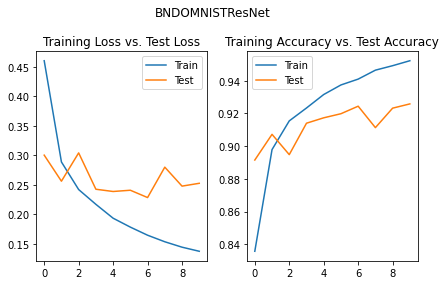

In [22]:
lr = 4e-3
model_name = str(model)[:str(model).index('(')]

optimizer = optax.adamw(learning_rate=lr)
rng, dropout_key = jax.random.split(rng)
state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
    batch_stats=batch_stats,
    dropout_key=dropout_key
)

train_end_to_end(
    state, "bndo", X_train, y_train, X_test, y_test, rng,
    lr=lr, num_epochs=10, batch_size=40, visualize=True, checkpoint=True, model_name=model_name
)